In [30]:
dependencies = ["mesa", "numpy", "pandas"]

In [31]:
import importlib
import subprocess
import sys

def install_and_import(package):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed")
    except ImportError:
        print(f"{package} is not installed, installing now...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} has been installed")

for package in dependencies:
    install_and_import(package)

mesa is already installed
numpy is already installed
pandas is already installed


In [32]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que exista más de un agente por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random
MAXVAL = 10000
random.seed(67890)
np.random.seed(67890)

In [33]:
#Nombre: Diego Reséndiz Fernández
#Matricula: A01708017
#Fecha de creacion: 16/05/2024
#Ultima fecha de modificación: 29/05/2024
#Sinopsis:

In [34]:
#Nombre: Box
#Parametros: Ninguno.
#Return: Nada
#Se encarga de servir como base para crear agentes de tipo caja

In [35]:
class Box(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

In [36]:
#Nombre: AgenteRobot
#Parametros: Ninguno.
#Return: Nada
#Se encarga de servir como base para crear agentes de tipo Agente Robot

In [37]:

class AgenteRobot(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)
    self.carryingBox = False
    self.targetPosition = None
    self.currentTarget = None
#Nombre:moveTowardsTarget
  #Parametros:self
  #Retorno:NA
  #Descripcion: funcion que sirve para llevar alagente deirectamente hacia su target guardado
  def moveTowardsTarget(self):
    currentX, currentY = self.pos
    targetX, targetY = self.targetPosition
    # Calcular la dirección del movimiento
    dx = targetX - currentX
    dy = targetY - currentY
    # Determinar el paso de movimiento en x y y
    stepX = 1 if dx > 0 else -1 if dx < 0 else 0
    stepY = 1 if dy > 0 else -1 if dy < 0 else 0
    # Crear una lista de posibles movimientos
    possibleMoves = []
    if stepX != 0:
      possibleMoves.append((currentX + stepX, currentY))
    if stepY != 0:
      possibleMoves.append((currentX, currentY + stepY))
        # Filtrar los movimientos posibles para mantener solo los vacíos
    possibleMoves = [move for move in possibleMoves if self.model.grid.is_cell_empty(move)]
    if possibleMoves:
      # Elegir el movimiento más cercano al objetivo
      moveToTarget = min(possibleMoves, key=lambda pos: self.model.grid.get_distance(pos, self.targetPosition))
      self.model.grid.move_agent(self, moveToTarget)
    else:
      # Si no hay movimientos posibles, quedarse en el mismo lugar
      self.targetPosition = None

#Nombre: move
  #Parametros:self
  #Retorno:NA
  #Descripcion:Fucnion que gestiona la logica de movimiento del agente para alternar entre moverse drectamente hacia un objetivo y vagar aleatoreamente
  def move(self):
   if self.currentTarget and self.carryingBox:
     self.moveTowardsTarget()
   else:
     self.randomMove()

#Nombre:randomMove
  #Parametros:self
  #Retorno:NA
  #Descripcion:Logica que mueve al agente de maner aleatorea por el tablero
  def randomMove(self):
    neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    emptyNeighbors = [neighbor for neighbor in neighbors if self.model.grid.is_cell_empty(neighbor)]
    if emptyNeighbors:
      if self.carryingBox and self.targetPosition:
        if self.pos == self.targetPosition:
          self.placeBox(self.pos)
          self.targetPosition = None
        else:
          newPosition = self.random.choice(emptyNeighbors)
          self.model.grid.move_agent(self, newPosition)

      else:
        newPosition = self.random.choice(emptyNeighbors)
        self.model.grid.move_agent(self, newPosition)

#Nombre:placeBox
  #Parametros:sef y pos
  #Retorno:NA
  #Descripcion:Funcion que sirve para gestionar la logica de colocar una caja
  def placeBox(self, pos):
    newBox = Box(self.model.next_id(), self.model)
    self.model.grid.place_agent(newBox, pos)
    self.carryingBox = False
    print(f'El agente {self.unique_id} colocó una caja en {pos}')
#Nombre:pickBox
  #Parametros:selfy pos
  #Retorno: NA
  #Descripcion:Funcion que sirve para gestionar la logica de tomar una caja
  def pickBox(self, pos):
    cellContents = self.model.grid.get_cell_list_contents(pos)
    for agent in cellContents:
      if isinstance(agent, Box):
        self.model.grid.remove_agent(agent)
        self.carryingBox = True
        print(f'El agente {self.unique_id} removio una caja en {pos}')
        return
  #Nombre:search
  #Parametros:self
  #Retorno: NA
  #Descripcion: Gestion de la logica para saber cuando tomar una caja, cuando colocarla, cuando guardar una posicion y saber si hay cajas en las casillas adyacentes
  def search(self):
    neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    for neighbor in neighbors:
      cellContents = self.model.grid.get_cell_list_contents(neighbor)
      numBoxes = sum(1 for agent in cellContents if isinstance(agent, Box))
      if numBoxes > 0:
        if self.carryingBox and numBoxes <= 4:
          self.placeBox(neighbor)
          return
        elif not self.carryingBox:
          if numBoxes <=3:
            self.pickBox(neighbor)
            return
        elif numBoxes > 3:
          self.targetPosition = neighbor
          return

#Nombre:Step
  #Parametros:self
  #Retorno: NA
  #Descripcion: Funcion que sirve para decirle al agente que debe de hacer en cada step
  def step(self):
    self.search()
    self.move()



In [38]:
#Nombre: getGrid
#Parametros: un model.
#Return: Nada
#Se encarga de crear una representación visual del estado actual de la cuadrícula en el modelo
def getGrid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            if not model.grid.is_cell_empty((x, y)):
                contents = model.grid.get_cell_list_contents((x, y))
                if any(isinstance(agent, Box) for agent in contents):
                  numBoxes = sum(1 for agent in contents if isinstance(agent,Box))
                  if(numBoxes == 5):
                    grid[x][y] = 2 # Asignar 2 si hay una pila completa en la celda
                  else:
                    grid[x][y] = 1  # Asignar 1 si hay una caja en la celda
                elif any(isinstance(agent, AgenteRobot) for agent in contents):
                  for agent in contents:
                    if isinstance(agent, AgenteRobot):
                      if agent.carryingBox:
                        grid[x][y] = 4  # Asignar 4 si hay un agente robot en la celda y tiene una caja
                      else:
                        grid[x][y] = 3  # Asignar 3 si hay un agente robot en la celda y no tiene una caja
            else:
                grid[x][y] = 0  # Celda vacía
    return grid

In [39]:
#Nombre: WarehouseModel
#Parametros: Ninguno.
#Return: Nada
#Se encarga de servir como base para hacer lso preparativos de la simulacion

In [40]:
class WarehouseModel(Model):
  def __init__(self, width, height, num_agents, num_boxes):
    super().__init__()
    self.cells = np.zeros((width, height))
    self.numAgents = num_agents
    self.numBoxes = num_boxes
    self.grid = MultiGrid(width, height, False)
    self.schedule = RandomActivation(self)
    self.dataCollector = DataCollector(model_reporters = {"Grid" : getGrid })
    self.currentStep = 0
    self.pileCount = 0
    self.maxBoxesPerPile = 5

    #Colocamos las cajas
    boxId = 0
    while self.numBoxes > 0:
      numBoxesInGroup = random.randint(1, 3)
      if numBoxesInGroup >= self.numBoxes:
        numBoxesInGroup = self.numBoxes
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      # Verificar el número de cajas en la celda
      cellContents = self.grid.get_cell_list_contents((x, y))
      numBoxesInCell = sum(1 for agent in cellContents if isinstance(agent, Box))
      if numBoxesInCell == 0:
        for _ in range(numBoxesInGroup):
          newBox = Box(boxId, self)
          self.grid.place_agent(newBox, (x, y))
          boxId += 1
        self.numBoxes -= numBoxesInGroup
        print(f'Cajas restantes: {self.numBoxes}')

     #Colocamos los agentes
    for _ in range(self.numAgents):
      emptyPositions = self.grid.empties
      if emptyPositions:
        position = self.random.choice(list(emptyPositions))
        agent = AgenteRobot(_, self)
        self.grid.place_agent(agent, position)
        self.schedule.add(agent)
 #Nombre:countPiles
  #Parametros:self
  #Retorno: NA
  #Descripcion: Funcion que sirve para contar el numero de pilas que existen en el tablero
  def countPiles(self):
    count = 0
    for x in range(self.grid.width):
      for y in range(self.grid.height):
        contents = self.grid.get_cell_list_contents((x, y))
        numBoxes = sum(1 for agent in contents if isinstance(agent, Box))
        if numBoxes == self.maxBoxesPerPile:
          count += 1
    self.pileCount = count
#Nombre:allBoxesStacked
  #Parametros:self
  #Retorno: NA
  #Descripcion: Funcion que sirve para hacer el control de la simulacion y determinar si ya debe de acabar o no. Esta funcion determina si se completaron las 40 cajas
  def allBoxesStacked(self):
    if self.pileCount == 40:
      return True
    else:
      return False
#Nombre:countTotalBoxes
  #Parametros:self
  #Retorno: NA
  #Descripcion:Funcion de Debug que sirve para saber cuantas cajas existen en total en el tablero
  def countTotalBoxes(self):
    totalBoxes = 0
    for x in range(self.grid.width):
      for y in range(self.grid.height):
        contents = self.grid.get_cell_list_contents((x, y))
        totalBoxes += sum(1 for agent in contents if isinstance(agent, Box))
    return totalBoxes
#Nombre:step
  #Parametros:self
  #Retorno: NA
  #Descripcion:Funcion que se encarga de hacer las iteraciones de la simulacion
  def step(self):
    self.countPiles()
    self.dataCollector.collect(self)
    self.schedule.step()
    self.currentStep += 1


In [41]:

GRIDSIZE = 20

MAXITER = 1500

AGENTNUM = 5

NUMBOXES = 202

startTime = time.time()

model = WarehouseModel(GRIDSIZE, GRIDSIZE, AGENTNUM, NUMBOXES)

#i=1
while not model.allBoxesStacked():
#while i < MAXITER:
  model.step()
  #i = i + 1

Cajas restantes: 201
Cajas restantes: 199
Cajas restantes: 196
Cajas restantes: 194
Cajas restantes: 191
Cajas restantes: 188
Cajas restantes: 185
Cajas restantes: 183
Cajas restantes: 181
Cajas restantes: 179
Cajas restantes: 177
Cajas restantes: 175
Cajas restantes: 174
Cajas restantes: 173
Cajas restantes: 170
Cajas restantes: 168
Cajas restantes: 167
Cajas restantes: 165
Cajas restantes: 162
Cajas restantes: 161
Cajas restantes: 160
Cajas restantes: 158
Cajas restantes: 157
Cajas restantes: 156
Cajas restantes: 153
Cajas restantes: 150
Cajas restantes: 147
Cajas restantes: 145
Cajas restantes: 142
Cajas restantes: 140
Cajas restantes: 138
Cajas restantes: 137
Cajas restantes: 134
Cajas restantes: 131
Cajas restantes: 129
Cajas restantes: 128
Cajas restantes: 125
Cajas restantes: 123
Cajas restantes: 121
Cajas restantes: 120
Cajas restantes: 118
Cajas restantes: 115
Cajas restantes: 114
Cajas restantes: 112
Cajas restantes: 111
Cajas restantes: 110
Cajas restantes: 107
Cajas restant

In [42]:
print('Valores de comprobacion')
model.countTotalBoxes()


Valores de comprobacion


202

In [43]:
#Despliege de los datos importantes.
totalTime = time.time() - startTime
print('Tiempo de ejecucion : %.5f segundos' % totalTime)
print(f'Tiempo necesario hasta que todas las cajas  estén apiladas: {model.currentStep} Steps')
print(f'pilas de 5 cajas al término de la simulación: {model.pileCount}')

Tiempo de ejecucion : 5.55923 segundos
Tiempo necesario hasta que todas las cajas  estén apiladas: 2363 Steps
pilas de 5 cajas al término de la simulación: 40


In [44]:
#Obtenemos la informacion requerida para el analsis.
allGrid = model.dataCollector.get_model_vars_dataframe()
print(allGrid)

                                                   Grid
0     [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1     [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2     [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3     [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4     [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
...                                                 ...
2358  [[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2359  [[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2360  [[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2361  [[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2362  [[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

[2363 rows x 1 columns]


Listo


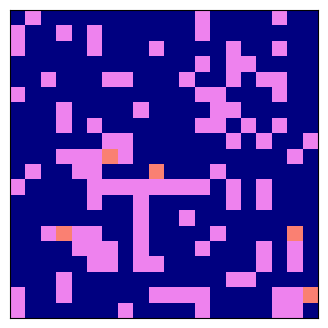

In [45]:
#Obtenemos la informacion en cada step y la graficamos para despues juntarla en una animacion
fig, axs=plt.subplots(figsize=(4,4))
axs.set_xticks([])
axs.set_yticks([])
cmap = ListedColormap(['navy', 'violet', 'tomato', 'purple', 'salmon'])
if not allGrid.empty:
  print("Listo")
  patch = plt.imshow(allGrid.iloc[0][0], cmap)
else:
  print("no :C")
  patch = plt.imshow(np.zeros((model.grid.width, model.grid.height)), cmap='viridis')

def animate(i):
  if i < len(allGrid):
    patch.set_data(allGrid.iloc[i][0])
  else:
    patch.set_data(allGrid.iloc[-1][0])  # Muestra el último estado disponible

anim = animation.FuncAnimation(fig, animate, frames=MAXITER, repeat=False)
plt.show()

In [46]:
#Llamamos la animacion
anim